<a href="https://www.kaggle.com/code/amirmotefaker/bank-customer-churn-prediction?scriptVersionId=136312268" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Bank Customer Churn Prediction

### What is churn analytics?
- Churn analytics is the process of measuring and understanding the rate at which customers quit the product, site, or service. 
- Churn analytics can help you understand how frequently customers churn out of the product and where this tends to occur. 
- Help you understand which features and functionality are important for keeping customers in your product. 
- Churn analytics is critical for getting a performance overview, identifying improvements and understanding which channels are driving the most value.

### Customer Churn Prediction - Bank

- Financial institutions have many clients close their accounts or migrate to other institutions.As a result, this has made a significant hole in sales and may significantly impact yearly revenues for the current fiscal year, leading stocks to plummet and market value to fall by a decent percentage.

- The objective of this project is that we want to build a model to predict, with reasonable accuracy, the customers who are going to churn soon.

- A customer having closed all their active accounts with the bank is said to have churned. Churn can be defined in other ways as well, based on the context of the problem. A customer not transacting for six months or one year can also be defined as churned based on the business requirements.



## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import subprocess  # Subprocess in Python is a module used to run new codes and applications by creating new processes.
import joblib  # Lightweight pipelining with Python functions

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, recall_score, confusion_matrix, classification_report 

# A fast, distributed, high performance gradient boosting (GBT, GBDT, GBRT, GBM or MART) framework 
# based on decision tree algorithms, used for ranking, classification and many other machine learning tasks.
from lightgbm import LGBMClassifier

# Get multiple outputs in the same cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Ignore all warnings
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Reading the DataSet

In [2]:
dc = pd.read_csv("/kaggle/input/churn-modeling-bank/Churn_Modelling.csv")

In [3]:
dc.head(5)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## Exploratory Data Analysis

In [4]:
# Dimension of the dataset
dc.shape

(10000, 14)

In [5]:
# Describe all numerical columns
dc.describe(exclude= ['O'])

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [6]:
# Describe all categorical columns
dc.describe(include = ['O'])

,Surname,Geography,Gender
count,10000,10000,10000
unique,2932,3,2
top,Smith,France,Male
freq,32,5014,5457


In [7]:
# Checking number of unique customers in the dataset
dc.shape[0], dc.CustomerId.nunique()

(10000, 10000)

- This means each row corresponds to a customer.

### Group by Surname to see the average churn value:

In [8]:
dc.groupby(['Surname']).agg({'RowNumber':'count', 'Exited':'mean'}
                                  ).reset_index().sort_values(by='RowNumber', ascending=False).head()

,Surname,RowNumber,Exited
2473,Smith,32,0.281250
1689,Martin,29,0.310345
2389,Scott,29,0.103448
2751,Walker,28,0.142857
336,Brown,26,0.192308


### Group by Geography:

In [9]:
dc.groupby(['Geography']).agg({'RowNumber':'count', 'Exited':'mean'}
                                  ).reset_index().sort_values(by='RowNumber', ascending=False)

,Geography,RowNumber,Exited
0,France,5014,0.161548
1,Germany,2509,0.324432
2,Spain,2477,0.166734


- From what we see above, customers from "Germany" have a higher exiting rate than average.

## Univariate Plots of Numerical Variables

<AxesSubplot:ylabel='CreditScore'>

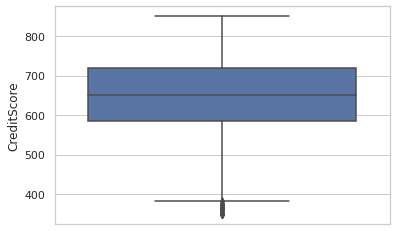

In [10]:
# Plotting CreditScore
sns.set(style="whitegrid")
sns.boxplot(y=dc['CreditScore'])

<AxesSubplot:ylabel='Age'>

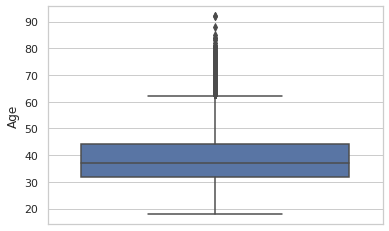

In [11]:
# Plotting Age
sns.boxplot(y=dc['Age'])

<AxesSubplot:ylabel='Tenure'>

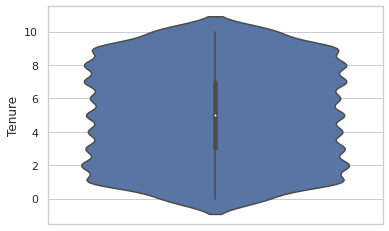

In [12]:
# Tenure violin plot
sns.violinplot(y = dc.Tenure)

<AxesSubplot:ylabel='Balance'>

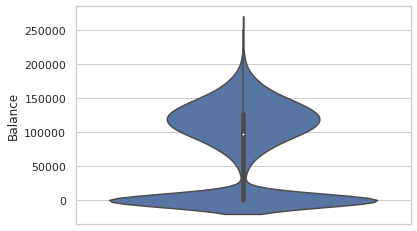

In [13]:
# Balance violin plot
sns.violinplot(y = dc['Balance'])

<AxesSubplot:xlabel='NumOfProducts'>

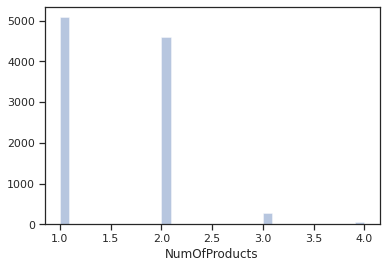

In [14]:
# Plotting a distribution plot of NumOfProducts
sns.set(style = 'ticks')
sns.distplot(dc.NumOfProducts, hist=True, kde=False)

- Most of the customers have 1 or 2 products.

<AxesSubplot:xlabel='EstimatedSalary', ylabel='Density'>

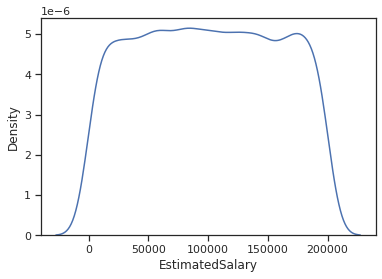

In [15]:
# Kernel density estimation plot for EstimatedSalary
# When dealing with numerical characteristics, one of the most useful statistics to examine is the data distribution.
# we can use Kernel-Density-Estimation plot for that purpose. 
sns.kdeplot(dc.EstimatedSalary)

## Data Preprocessing
- Tips:

    - We will discard the RowNumber column.
    - We will discard CustomerID as well since it doesn't convey any extra info. Each row pertains to a unique customer.
    - Features can be segregated into non-essential, numerical, categorical, and target variables based on the above.
    - CustomerID is a handy feature based on which we can calculate many user-centric features.

In [16]:
# Separating out different columns into various categories as defined above
target_var = ['Exited']
cols_to_remove = ['RowNumber', 'CustomerId']

# numerical columns
num_feats = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

# categorical columns
cat_feats = ['Surname', 'Geography', 'Gender', 'HasCrCard', 'IsActiveMember']

- Tenure and NumOfProducts are ordinal variables.
- HasCrCard and IsActiveMember are binary categorical variables.

In [17]:
# Separating target variable and removing the non-essential columns
y = dc[target_var].values
dc.drop(cols_to_remove, axis=1, inplace=True)

### Splitting Dataset
- We keep aside a test set to evaluate our model at the very end to estimate our chosen model's performance on unseen data.
- A validation set is also created, which we'll use in our baseline models to evaluate and tune our models.

In [18]:
# Keeping aside a test/holdout set
dc_train_val, dc_test, y_train_val, y_test = train_test_split(dc, y.ravel(), test_size = 0.1, random_state = 42)

# Splitting into train and validation set
dc_train, dc_val, y_train, y_val = train_test_split(dc_train_val, y_train_val, test_size = 0.12, random_state = 42)
dc_train.shape, dc_val.shape, dc_test.shape, y_train.shape, y_val.shape, y_test.shape
np.mean(y_train), np.mean(y_val), np.mean(y_test)

((7920, 12), (1080, 12), (1000, 12), (7920,), (1080,), (1000,))

(0.20303030303030303, 0.22037037037037038, 0.191)

## Categorical Variable Encoding
1- Label Encoding: transforms non-numerical labels into numerical ones. It can be used for binary categorical and ordinal variables.

2- One-Hot encoding: encodes categorical features as a one-hot numeric array. It can be used for non-ordinal categorical variables with low to mid cardinality (< 5-10 levels)

3- Target encoding: the technique of substituting a categorical value with the mean of the target variable is known as target encoding. The target encoder model automatically removes any non-categorical columns. It can be used for Categorical variables with > 10 levels

    - HasCrCard and IsActiveMember are already label encoded.

    - Gender, a simple label encoding should be acceptable.

    - Geography, since there are three levels, one-hot encoding should do the trick.

    - Surname, we'll try target/frequency encoding.

## 1- Label Encoding

### Label Encoding for Binary Variables

- Label encoding on the Gender column.


In [19]:
# label encoding With  the sklearn method
le = LabelEncoder()
# Label encoding of Gender variable
dc_train['Gender'] = le.fit_transform(dc_train['Gender'])
le_gender_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
le_gender_mapping

{'Female': 0, 'Male': 1}

### Testing and validation sets

In [20]:
# Encoding Gender feature for validation and test set
dc_val['Gender'] = dc_val.Gender.map(le_gender_mapping)
dc_test['Gender'] = dc_test.Gender.map(le_gender_mapping)

# Filling missing/NaN values created due to new categorical levels
dc_val['Gender'].fillna(-1, inplace=True)
dc_test['Gender'].fillna(-1, inplace=True)

### Checking the values on all sets

In [21]:
dc_train.Gender.unique(), dc_val.Gender.unique(), dc_test.Gender.unique()

(array([1, 0]), array([1, 0]), array([1, 0]))

## 2- One-Hot encoding

### One-hot Encoding Categorical Variables

In [22]:
# one-hot encode the Geography column

# With the sklearn method(LabelEncoder())
le_ohe = LabelEncoder()
ohe = OneHotEncoder(handle_unknown = 'ignore', sparse=False)
enc_train = le_ohe.fit_transform(dc_train.Geography).reshape(dc_train.shape[0],1)
ohe_train = ohe.fit_transform(enc_train)
ohe_train

array([[0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [23]:
# mapping between classes
le_ohe_geography_mapping = dict(zip(le_ohe.classes_, le_ohe.transform(le_ohe.classes_)))
le_ohe_geography_mapping

{'France': 0, 'Germany': 1, 'Spain': 2}

### Testing and validation sets

In [24]:
# Encoding Geography feature for validation and test set
enc_val = dc_val.Geography.map(le_ohe_geography_mapping).ravel().reshape(-1,1)
enc_test = dc_test.Geography.map(le_ohe_geography_mapping).ravel().reshape(-1,1)

# Filling missing/NaN values created due to new categorical levels
enc_val[np.isnan(enc_val)] = 9999
enc_test[np.isnan(enc_test)] = 9999
ohe_val = ohe.transform(enc_val)
ohe_test = ohe.transform(enc_test)

- In case there is a country that isn't present in the training set, the resulting vector will simply be [0, 0, 0]:

In [25]:
# Show what happens when a new value is inputted into the OHE 
ohe.transform(np.array([[9999]]))

array([[0., 0., 0.]])

### Adding the one-hot encoded columns to the data frame and removing the original feature:

In [26]:
cols = ['country_' + str(x) for x in le_ohe_geography_mapping.keys()]
cols

['country_France', 'country_Germany', 'country_Spain']

In [27]:
# Adding to the respective dataframes
dc_train = pd.concat([dc_train.reset_index(), pd.DataFrame(ohe_train, columns = cols)], axis = 1).drop(['index'], axis=1)
dc_val = pd.concat([dc_val.reset_index(), pd.DataFrame(ohe_val, columns = cols)], axis = 1).drop(['index'], axis=1)
dc_test = pd.concat([dc_test.reset_index(), pd.DataFrame(ohe_test, columns = cols)], axis = 1).drop(['index'], axis=1)
print("Training set")
dc_train.head()
print("\n\nValidation set")
dc_val.head()
print("\n\nTest set")
dc_test.head()

Training set


,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,country_France,country_Germany,country_Spain
0,Yermakova,678,Germany,1,36,1,117864.85,2,1,0,27619.06,0,0.0,1.0,0.0
1,Warlow-Davies,613,France,0,27,5,125167.74,1,1,0,199104.52,0,1.0,0.0,0.0
2,Fu,628,France,1,45,9,0.00,2,1,1,96862.56,0,1.0,0.0,0.0
3,Shih,513,France,1,30,5,0.00,2,1,0,162523.66,0,1.0,0.0,0.0
4,Mahmood,639,France,1,22,4,0.00,2,1,0,28188.96,0,1.0,0.0,0.0




Validation set


,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,country_France,country_Germany,country_Spain
0,Sun,757,France,1,36,7,144852.06,1,0,0,130861.95,0,1.0,0.0,0.0
1,Russo,552,France,1,29,10,0.00,2,1,0,12186.83,0,1.0,0.0,0.0
2,Munro,619,France,0,30,7,70729.17,1,1,1,160948.87,0,1.0,0.0,0.0
3,Perkins,633,France,1,35,10,0.00,2,1,0,65675.47,0,1.0,0.0,0.0
4,Aliyeva,698,Spain,1,38,10,95010.92,1,1,1,105227.86,0,0.0,0.0,1.0




Test set


,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,country_France,country_Germany,country_Spain
0,Anderson,596,Germany,1,32,3,96709.07,2,0,0,41788.37,0,0.0,1.0,0.0
1,Herring,623,France,1,43,1,0.00,2,1,1,146379.30,0,1.0,0.0,0.0
2,Amechi,601,Spain,0,44,4,0.00,2,1,0,58561.31,0,0.0,0.0,1.0
3,Liang,506,Germany,1,59,8,119152.10,2,1,1,170679.74,0,0.0,1.0,0.0
4,Chuang,560,Spain,0,27,7,124995.98,1,1,1,114669.79,0,0.0,0.0,1.0


### Dropping the original Geography column now:

In [28]:
dc_train.drop(['Geography'], axis=1, inplace=True)
dc_val.drop(['Geography'], axis=1, inplace=True)
dc_test.drop(['Geography'], axis=1, inplace=True)

In [29]:
# dataframes without Geography
print("Training set")
dc_train.head()
print("\n\nValidation set")
dc_val.head()
print("\n\nTest set")
dc_test.head()

Training set


,Surname,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,country_France,country_Germany,country_Spain
0,Yermakova,678,1,36,1,117864.85,2,1,0,27619.06,0,0.0,1.0,0.0
1,Warlow-Davies,613,0,27,5,125167.74,1,1,0,199104.52,0,1.0,0.0,0.0
2,Fu,628,1,45,9,0.00,2,1,1,96862.56,0,1.0,0.0,0.0
3,Shih,513,1,30,5,0.00,2,1,0,162523.66,0,1.0,0.0,0.0
4,Mahmood,639,1,22,4,0.00,2,1,0,28188.96,0,1.0,0.0,0.0




Validation set


,Surname,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,country_France,country_Germany,country_Spain
0,Sun,757,1,36,7,144852.06,1,0,0,130861.95,0,1.0,0.0,0.0
1,Russo,552,1,29,10,0.00,2,1,0,12186.83,0,1.0,0.0,0.0
2,Munro,619,0,30,7,70729.17,1,1,1,160948.87,0,1.0,0.0,0.0
3,Perkins,633,1,35,10,0.00,2,1,0,65675.47,0,1.0,0.0,0.0
4,Aliyeva,698,1,38,10,95010.92,1,1,1,105227.86,0,0.0,0.0,1.0




Test set


,Surname,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,country_France,country_Germany,country_Spain
0,Anderson,596,1,32,3,96709.07,2,0,0,41788.37,0,0.0,1.0,0.0
1,Herring,623,1,43,1,0.00,2,1,1,146379.30,0,1.0,0.0,0.0
2,Amechi,601,0,44,4,0.00,2,1,0,58561.31,0,0.0,0.0,1.0
3,Liang,506,1,59,8,119152.10,2,1,1,170679.74,0,0.0,1.0,0.0
4,Chuang,560,0,27,7,124995.98,1,1,1,114669.79,0,0.0,0.0,1.0


## 3- Target encoding
- Target encoding is generally proper when dealing with categorical variables of high cardinality (high number of levels).


### Encode the Surname column (which has 2932 different values!) with the mean of the target variable for that level:

In [30]:
means = dc_train.groupby(['Surname']).Exited.mean()
means.head()
means.tail()

Surname
Abazu       0.00
Abbie       0.00
Abbott      0.25
Abdullah    1.00
Abdulov     0.00
Name: Exited, dtype: float64

Surname
Zubarev     0.0
Zubareva    0.0
Zuev        0.0
Zuyev       0.0
Zuyeva      0.0
Name: Exited, dtype: float64

### Global mean of Exited column:

In [31]:
global_mean = y_train.mean()
global_mean

0.20303030303030303

In [32]:
# Creating new encoded features for surname - Target (mean) encoding
dc_train['Surname_mean_churn'] = dc_train.Surname.map(means)
dc_train['Surname_mean_churn'].fillna(global_mean, inplace=True)

- The problem with target encoding is that it might cause "data leakage", as we are considering feedback from the target variable while computing any summary statistic.
    - A solution is to use a modified version: Leave-one-out Target encoding; for a particular data point or row, the mean of the target is calculated by considering all rows in the same definite level except itself. It mitigates data leakage and overfitting to some extent.

### Calculating the frequency of each Surname:

In [33]:
freqs = dc_train.groupby(['Surname']).size()
freqs.head()

Surname
Abazu       2
Abbie       1
Abbott      4
Abdullah    1
Abdulov     1
dtype: int64

### Create frequency encoding - Number of instances of each category in the data:

In [34]:
dc_train['Surname_freq'] = dc_train.Surname.map(freqs)
dc_train['Surname_freq'].fillna(0, inplace=True)

### Creating Leave-one-out target encoding for Surname:

In [35]:
dc_train['Surname_enc'] = ((dc_train.Surname_freq * dc_train.Surname_mean_churn) - dc_train.Exited)/(dc_train.Surname_freq - 1)

# Fill NaNs occuring due to category frequency being 1 or less
dc_train['Surname_enc'].fillna((((dc_train.shape[0] * global_mean) - dc_train.Exited) / (dc_train.shape[0] - 1)), inplace=True)
dc_train.head(5)

,Surname,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,country_France,country_Germany,country_Spain,Surname_mean_churn,Surname_freq,Surname_enc
0,Yermakova,678,1,36,1,117864.85,2,1,0,27619.06,0,0.0,1.0,0.0,0.000000,4,0.000000
1,Warlow-Davies,613,0,27,5,125167.74,1,1,0,199104.52,0,1.0,0.0,0.0,0.000000,2,0.000000
2,Fu,628,1,45,9,0.00,2,1,1,96862.56,0,1.0,0.0,0.0,0.200000,10,0.222222
3,Shih,513,1,30,5,0.00,2,1,0,162523.66,0,1.0,0.0,0.0,0.285714,21,0.300000
4,Mahmood,639,1,22,4,0.00,2,1,0,28188.96,0,1.0,0.0,0.0,0.333333,3,0.500000


### On the validation and testing set, we'll apply the regular target encoding mapping as obtained from the training set:

In [36]:
# Replacing by category means and new category levels by global mean
dc_val['Surname_enc'] = dc_val.Surname.map(means)
dc_val['Surname_enc'].fillna(global_mean, inplace=True)
dc_test['Surname_enc'] = dc_test.Surname.map(means)
dc_test['Surname_enc'].fillna(global_mean, inplace=True)

# Show that using LOO Target encoding decorrelates features
dc_train[['Surname_mean_churn', 'Surname_enc', 'Exited']].corr()

,Surname_mean_churn,Surname_enc,Exited
Surname_mean_churn,1.000000,0.54823,0.562677
Surname_enc,0.548230,1.00000,-0.026440
Exited,0.562677,-0.02644,1.000000


- As you can see, "Surname_enc" isn't highly correlated with "Exited" as "Surname_mean_churn", so Leave-one-out is effective here.

### Deleting the Surname and other redundant columns across the three datasets:

In [37]:
dc_train.drop(['Surname_mean_churn'], axis=1, inplace=True)
dc_train.drop(['Surname_freq'], axis=1, inplace=True)
dc_train.drop(['Surname'], axis=1, inplace=True)
dc_val.drop(['Surname'], axis=1, inplace=True)
dc_test.drop(['Surname'], axis=1, inplace=True)

In [38]:
dc_train.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,country_France,country_Germany,country_Spain,Surname_enc
0,678,1,36,1,117864.85,2,1,0,27619.06,0,0.0,1.0,0.0,0.000000
1,613,0,27,5,125167.74,1,1,0,199104.52,0,1.0,0.0,0.0,0.000000
2,628,1,45,9,0.00,2,1,1,96862.56,0,1.0,0.0,0.0,0.222222
3,513,1,30,5,0.00,2,1,0,162523.66,0,1.0,0.0,0.0,0.300000
4,639,1,22,4,0.00,2,1,0,28188.96,0,1.0,0.0,0.0,0.500000


### Summary:
- Use label encoding and one-hot encoding on the training set and then save the mapping and apply it to the test set. For missing values, use 0, -1 etc.

- Target/Frequency encoding: Create a mapping between each level and a statistical measure (mean, median, sum, etc.) of the target from the training dataset. For the new categorical levels, impute the missing values suitably (can be 0, -1, or mean/mode/median).

- Leave-one-out or Cross-fold Target encoding avoids data leakage and helps generalize the model.

## Bivariate Analysis

### Checking the linear correlation between individual features and the target variable:

In [39]:
corr = dc_train.corr()

<AxesSubplot:>

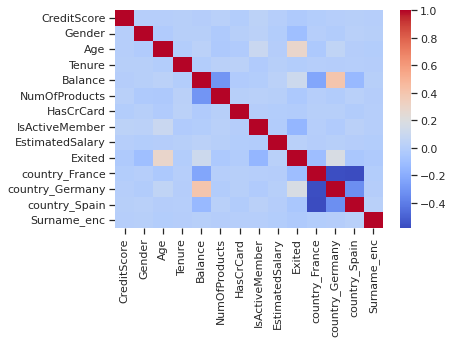

In [40]:
# Drawing a heatmap
sns.heatmap(corr, cmap = 'coolwarm')

- None of the features are highly correlated with the target variable. But some of them have slight linear associations with the target variable:

    - Continuous features: Age, Balance.
    - Categorical variables: Gender, IsActiveMember, country_Germany, country_France.

### Individual features versus their distribution across target variable values, for "Age" column:

<AxesSubplot:xlabel='Exited', ylabel='Age'>

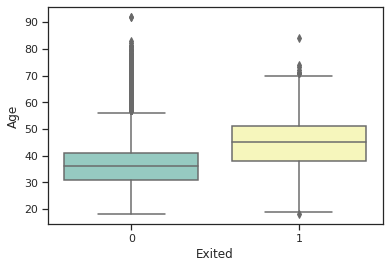

In [41]:
sns.boxplot(x="Exited", y="Age", data=dc_train, palette="Set3")

- Tips:
    - There is an outside point at 90 for class 0 and 83 for class 1.
    - The Median is around 35 for class 0 and 45 for class 1.
    - The lower adjacent value is a bit less than 20 for both classes.
    - The upper adjoining value is around 55 for class 0 and more than 70 for class 1.

### Violin plot for the "Balance":

<AxesSubplot:xlabel='Exited', ylabel='Balance'>

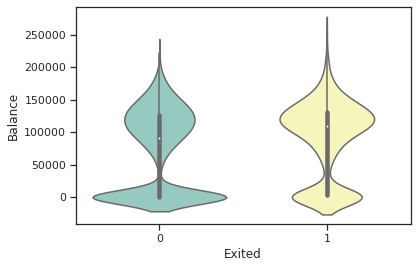

In [42]:
sns.violinplot(x="Exited", y="Balance", data=dc_train, palette="Set3")

- We see a high probability of observation at 125000 (balance) and a peak at 0 (balance) for class 0.

### Checking the association of categorical features with the target variable:

In [43]:
cat_vars_bv = ['Gender', 'IsActiveMember', 'country_Germany', 'country_France']

for col in cat_vars_bv:
    dc_train.groupby([col]).Exited.mean()
    print()

Gender
0    0.248191
1    0.165511
Name: Exited, dtype: float64

IsActiveMember
0    0.266285
1    0.143557
Name: Exited, dtype: float64

country_Germany
0.0    0.163091
1.0    0.324974
Name: Exited, dtype: float64

country_France
0.0    0.245877
1.0    0.160593
Name: Exited, dtype: float64

- From the above results, we can observe that the mean of the churned customer across "Germany" is higher than the others.

### Computed mean on churned or non chuned custmers group by number of product on training data

In [44]:
col = 'NumOfProducts'
dc_train.groupby([col]).Exited.mean()

# unique "NumOfProducts" on training data
dc_train[col].value_counts()

NumOfProducts
1    0.273428
2    0.076881
3    0.825112
4    1.000000
Name: Exited, dtype: float64

1    4023
2    3629
3     223
4      45
Name: NumOfProducts, dtype: int64

- All customers with four products have churned.
- About 82.5% of customers with three products have churned.

### Creating some new features based on simple interactions between the existing features:

In [45]:
eps = 1e-6

dc_train['bal_per_product'] = dc_train.Balance/(dc_train.NumOfProducts + eps)
dc_train['bal_by_est_salary'] = dc_train.Balance/(dc_train.EstimatedSalary + eps)
dc_train['tenure_age_ratio'] = dc_train.Tenure/(dc_train.Age + eps)
dc_train['age_surname_mean_churn'] = np.sqrt(dc_train.Age) * dc_train.Surname_enc

In [46]:
new_cols = ['bal_per_product', 'bal_by_est_salary', 'tenure_age_ratio', 'age_surname_mean_churn']

# Ensuring that the new column doesn't have any missing values
dc_train[new_cols].isnull().sum()

bal_per_product           0
bal_by_est_salary         0
tenure_age_ratio          0
age_surname_mean_churn    0
dtype: int64

### Linear association of new columns with target variables to judge importance:


<AxesSubplot:>

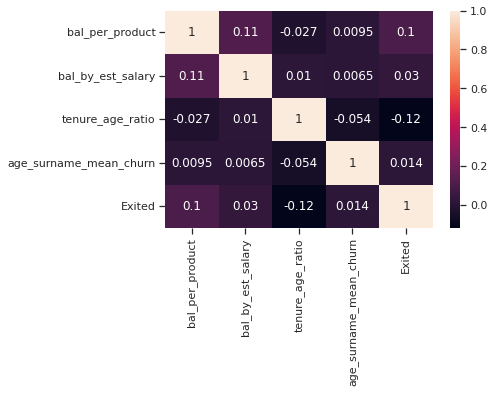

In [47]:
sns.heatmap(dc_train[new_cols + ['Exited']].corr(), annot=True)

- Out of the new features, ones with slight linear association/correlation are "bal_per_product" and "tenure_age_ratio".

### Creating them on the validation and testing sets:

In [48]:
dc_val['bal_per_product'] = dc_val.Balance/(dc_val.NumOfProducts + eps)
dc_val['bal_by_est_salary'] = dc_val.Balance/(dc_val.EstimatedSalary + eps)
dc_val['tenure_age_ratio'] = dc_val.Tenure/(dc_val.Age + eps)
dc_val['age_surname_mean_churn'] = np.sqrt(dc_val.Age) * dc_val.Surname_enc
dc_test['bal_per_product'] = dc_test.Balance/(dc_test.NumOfProducts + eps)
dc_test['bal_by_est_salary'] = dc_test.Balance/(dc_test.EstimatedSalary + eps)
dc_test['tenure_age_ratio'] = dc_test.Tenure/(dc_test.Age + eps)
dc_test['age_surname_mean_churn'] = np.sqrt(dc_test.Age) * dc_test.Surname_enc

## Feature Scaling and Normalization

### Scale the continuous columns with the "StandardScaler":

In [49]:
# initialize the standard scaler
sc = StandardScaler()
cont_vars = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary', 'Surname_enc', 'bal_per_product'
             , 'bal_by_est_salary', 'tenure_age_ratio', 'age_surname_mean_churn']
cat_vars = ['Gender', 'HasCrCard', 'IsActiveMember', 'country_France', 'country_Germany', 'country_Spain']

# Scaling only continuous columns
cols_to_scale = cont_vars
sc_X_train = sc.fit_transform(dc_train[cols_to_scale])

# Converting from array to dataframe and naming the respective features/columns
sc_X_train = pd.DataFrame(data=sc_X_train, columns=cols_to_scale)
sc_X_train.shape
sc_X_train.head()

(7920, 11)

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Surname_enc,bal_per_product,bal_by_est_salary,tenure_age_ratio,age_surname_mean_churn
0,0.284761,-0.274383,-1.389130,0.670778,0.804059,-1.254732,-1.079210,-0.062389,0.095448,-1.232035,-1.062507
1,-0.389351,-1.128482,-0.004763,0.787860,-0.912423,1.731950,-1.079210,1.104840,-0.118834,0.525547,-1.062507
2,-0.233786,0.579716,1.379604,-1.218873,0.804059,-0.048751,0.094549,-1.100925,-0.155854,0.690966,0.193191
3,-1.426446,-0.843782,-0.004763,-1.218873,0.804059,1.094838,0.505364,-1.100925,-0.155854,0.318773,0.321611
4,-0.119706,-1.602981,-0.350855,-1.218873,0.804059,-1.244806,1.561746,-1.100925,-0.155854,0.487952,0.912973


In [50]:
# Scaling validation and test sets by transforming the mapping obtained through the training set
sc_X_val = sc.transform(dc_val[cols_to_scale])
sc_X_test = sc.transform(dc_test[cols_to_scale])

# Converting val and test arrays to dataframes for re-usability
sc_X_val = pd.DataFrame(data=sc_X_val, columns=cols_to_scale)
sc_X_test = pd.DataFrame(data=sc_X_test, columns=cols_to_scale)

In [51]:
sc_X_test.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Surname_enc,bal_per_product,bal_by_est_salary,tenure_age_ratio,age_surname_mean_churn
0,-0.565657,-0.653982,-0.696947,0.331601,0.804059,-1.007952,-0.639050,-0.248798,-0.019574,-0.495401,-0.665420
1,-0.285641,0.389916,-1.389130,-1.218873,0.804059,0.813659,-0.006822,-1.100925,-0.155854,-1.282526,0.058960
2,-0.513802,0.484816,-0.350855,-1.218873,0.804059,-0.715825,0.681428,-1.100925,-0.155854,-0.527123,0.799993
3,-1.499042,1.908314,1.033512,0.691415,0.804059,1.236889,-0.266608,-0.051047,-0.114744,-0.028188,-0.067092
4,-0.939011,-1.128482,0.687420,0.785106,-0.912423,0.261390,0.139693,1.101813,-0.091664,1.352644,-0.052438


## Feature Selection using RFE

- Feature scaling is essential for algorithms like Logistic Regression and SVM.
- Feature scaling is not necessarily crucial for tree-based models such as decision trees.

- We can perform feature selection by eliminating features from the training dataset through Recursive Feature Elimination (RFE).
- Features shortlisted through EDA/manual inspection and bivariate analysis:

    - Age, Gender, Balance, NumOfProducts, IsActiveMember, the three Geography variables, bal_per_product, tenure_age_ratio.
    
- let's see whether feature selection and elimination through RFE give us the same list of features, other extra features, or a lesser number of features.

### To begin with, we'll feed all features to the RFE and LogReg model:

In [52]:
# Creating feature-set and target for RFE model
y = dc_train['Exited'].values
X = dc_train[cat_vars + cont_vars]
X.columns = cat_vars + cont_vars
X.columns

Index(['Gender', 'HasCrCard', 'IsActiveMember', 'country_France',
       'country_Germany', 'country_Spain', 'CreditScore', 'Age', 'Tenure',
       'Balance', 'NumOfProducts', 'EstimatedSalary', 'Surname_enc',
       'bal_per_product', 'bal_by_est_salary', 'tenure_age_ratio',
       'age_surname_mean_churn'],
      dtype='object')

### We want to select the features (you can change that if you wish to), so we set n_features_to_select as 10:

In [53]:
# for logistics regression
rfe = RFE(estimator=LogisticRegression(), n_features_to_select=10) 
rfe = rfe.fit(X.values, y) 

# mask of selected features
print(rfe.support_)
# The feature ranking, such that ranking_[i] corresponds to the ranking position of the i-th feature 
print(rfe.ranking_)

[ True  True  True  True  True  True False  True False False  True False
  True False False  True False]
[1 1 1 1 1 1 4 1 3 6 1 8 1 7 5 1 2]


- Printed the selected features as well as the ranking of the feature by importance.

### Logistic regression (linear)

In [54]:
mask = rfe.support_.tolist()
selected_feats = [b for a,b in zip(mask, X.columns) if a]
selected_feats

['Gender',
 'HasCrCard',
 'IsActiveMember',
 'country_France',
 'country_Germany',
 'country_Spain',
 'Age',
 'NumOfProducts',
 'Surname_enc',
 'tenure_age_ratio']

- Features that were chosen for logistic regression.

In [55]:
rfe_dt = RFE(estimator=DecisionTreeClassifier(max_depth = 4, criterion = 'entropy'), n_features_to_select=10) 
rfe_dt = rfe_dt.fit(X.values, y)  
mask = rfe_dt.support_.tolist()
selected_feats_dt = [b for a,b in zip(mask, X.columns) if a]
selected_feats_dt

['IsActiveMember',
 'country_Germany',
 'Age',
 'NumOfProducts',
 'EstimatedSalary',
 'Surname_enc',
 'bal_per_product',
 'bal_by_est_salary',
 'tenure_age_ratio',
 'age_surname_mean_churn']

- Features that were chosen for the decision tree model.

## Baseline Model 1: Logistic Regression

### Train the linear models on the features selected with RFE:

In [56]:
selected_cat_vars = [x for x in selected_feats if x in cat_vars]
selected_cont_vars = [x for x in selected_feats if x in cont_vars]

# Using categorical features and scaled numerical features
X_train = np.concatenate((dc_train[selected_cat_vars].values, sc_X_train[selected_cont_vars].values), axis=1)
X_val = np.concatenate((dc_val[selected_cat_vars].values, sc_X_val[selected_cont_vars].values), axis=1)
X_test = np.concatenate((dc_test[selected_cat_vars].values, sc_X_test[selected_cont_vars].values), axis=1)

# print the shapes
X_train.shape, X_val.shape, X_test.shape

((7920, 10), (1080, 10), (1000, 10))

- During the training phase, the weight differential will affect the classification of the classes.

### The overall goal is to penalize the minority class for misclassification by increasing class weight while decreasing weight for the majority class:

In [57]:
# Obtaining class weights based on the class samples imbalance ratio
_, num_samples = np.unique(y_train, return_counts=True)
weights = np.max(num_samples)/num_samples

# Define weight dictionnary
weights_dict = dict()
class_labels = [0,1]

# Weights associated with classes
for a,b in zip(class_labels,weights):
    weights_dict[a] = b

weights_dict

{0: 1.0, 1: 3.925373134328358}

### Retrain with class_weight:

In [58]:
# Defining model
lr = LogisticRegression(C=1.0, penalty='l2', class_weight=weights_dict, n_jobs=-1)

# train
lr.fit(X_train, y_train)
print(f'Confusion Matrix: \n{confusion_matrix(y_val, lr.predict(X_val))}')
print(f'Area Under Curve: {roc_auc_score(y_val, lr.predict(X_val))}')
print(f'Recall score: {recall_score(y_val,lr.predict(X_val))}')
print(f'Classification report: \n{classification_report(y_val,lr.predict(X_val))}')

LogisticRegression(class_weight={0: 1.0, 1: 3.925373134328358}, n_jobs=-1)

Confusion Matrix: 
[[590 252]
 [ 71 167]]
Area Under Curve: 0.7011966306712709
Recall score: 0.7016806722689075
Classification report: 
              precision    recall  f1-score   support

           0       0.89      0.70      0.79       842
           1       0.40      0.70      0.51       238

    accuracy                           0.70      1080
   macro avg       0.65      0.70      0.65      1080
weighted avg       0.78      0.70      0.72      1080



## Baseline Model 2: Support Vector Machines(SVM)

### Train an SVC:

In [59]:
svm = SVC(C=1.0, kernel="linear", class_weight=weights_dict)
svm.fit(X_train, y_train)

SVC(class_weight={0: 1.0, 1: 3.925373134328358}, kernel='linear')

### Note:
- In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook.
- On GitHub, the HTML representation is unable to render, please try loading this page with [nbviewer](https://nbviewer.org/)

### Validation metrics


In [60]:
print(f'Confusion Matrix: {confusion_matrix(y_val, lr.predict(X_val))}')
print(f'Area Under Curve: {roc_auc_score(y_val, lr.predict(X_val))}')
print(f'Recall score: {recall_score(y_val,lr.predict(X_val))}')
print(f'Classification report: \n{classification_report(y_val,lr.predict(X_val))}')

Confusion Matrix: [[590 252]
 [ 71 167]]
Area Under Curve: 0.7011966306712709
Recall score: 0.7016806722689075
Classification report: 
              precision    recall  f1-score   support

           0       0.89      0.70      0.79       842
           1       0.40      0.70      0.51       238

    accuracy                           0.70      1080
   macro avg       0.65      0.70      0.65      1080
weighted avg       0.78      0.70      0.72      1080



## Plotting Decision Boundaries of Linear Models
- To plot the decision boundaries of classification models in a 2-D space, we first need to train our models in a 2D space.
- The best option is to use our existing data (with > 2 features) and apply dimensionality reduction techniques (like PCA) to it and then train our models on this data with a reduced number of features.

- We will create an image in Meshgrid in which each pixel represents a grid cell in the 2D feature space.
- Over the 2D feature space, the image creates a grid. The classifier is used to classify the image's pixels, assigning a class label to each grid cell.
- The identified image is then utilized as the backdrop for a scatter plot with data points from each class.

In [61]:
pca = PCA(n_components=2)

# Transforming the dataset using PCA
X_pca = pca.fit_transform(X_train)
y = y_train
X_pca.shape, y.shape

((7920, 2), (7920,))

LogisticRegression(class_weight={0: 1.0, 1: 3.925373134328358}, n_jobs=-1)

SVC(class_weight={0: 1.0, 1: 3.925373134328358}, kernel='linear')

<AxesSubplot:>

Text(0.5, 1.0, 'Linear models - LogReg and SVM')

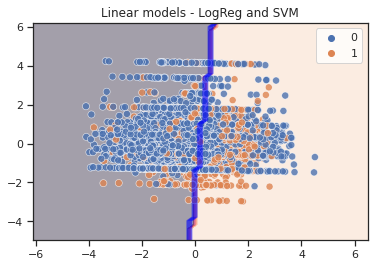

In [62]:
# min and max values 
xmin, xmax = X_pca[:, 0].min() - 2, X_pca[:, 0].max() + 2
ymin, ymax = X_pca[:, 1].min() - 2, X_pca[:, 1].max() + 2

# Creating a mesh region where the boundary will be plotted
xx, yy = np.meshgrid(np.arange(xmin, xmax, 0.2),
                     np.arange(ymin, ymax, 0.2))

# Fitting LR model on 2 features
lr.fit(X_pca, y)

# Fitting SVM model on 2 features
svm.fit(X_pca, y)

# Plotting decision boundary for LR
z1 = lr.predict(np.c_[xx.ravel(), yy.ravel()])
z1 = z1.reshape(xx.shape)

# Plotting decision boundary for SVM
z2 = svm.predict(np.c_[xx.ravel(), yy.ravel()])
z2 = z2.reshape(xx.shape)

# Displaying the result
plt.contourf(xx, yy, z1, alpha=0.4) # LR
plt.contour(xx, yy, z2, alpha=0.4, colors='blue') # SVM
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y_train, s=50, alpha=0.8)
plt.title('Linear models - LogReg and SVM')

### Tips:
- Logistic regression estimator uses a linear separator for decision boundary.
- The Support Vector Machine finds a hyperplane with the maximum margin that divides the feature space into two classes.
- Decision Dense sampling with a mesh grid may be used to illustrate decision boundary. However, the boundaries will seem erroneous if the grid resolution is insufficient. Mesh grid aims to generate a rectangular grid from an array of x values and an array of y values.

### Note:
- In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook.
- On GitHub, the HTML representation is unable to render, please try loading this page with [nbviewer](https://nbviewer.org/)

## Baseline Model 3 (Non-linear): Decision Tree Classifier
- Decision Trees are among the easiest algorithms to grasp, and their rationale is straightforward to explain.

In [63]:
# Features selected from the RFE process
selected_feats_dt

['IsActiveMember',
 'country_Germany',
 'Age',
 'NumOfProducts',
 'EstimatedSalary',
 'Surname_enc',
 'bal_per_product',
 'bal_by_est_salary',
 'tenure_age_ratio',
 'age_surname_mean_churn']

In [64]:
# Re-defining X_train and X_val to consider original unscaled continuous features. y_train and y_val remain unaffected
X_train = dc_train[selected_feats_dt].values
X_val = dc_val[selected_feats_dt].values

# Decision tree classiier model
clf = DecisionTreeClassifier(criterion='entropy', class_weight=weights_dict, max_depth=4, max_features=None
                            , min_samples_split=25, min_samples_leaf=15)

# Fit the model
clf.fit(X_train, y_train)

# Checking the importance of different features of the model
pd.DataFrame({'features': selected_feats,
              'importance': clf.feature_importances_
             }).sort_values(by='importance', ascending=False)

DecisionTreeClassifier(class_weight={0: 1.0, 1: 3.925373134328358},
                       criterion='entropy', max_depth=4, min_samples_leaf=15,
                       min_samples_split=25)

,features,importance
2,IsActiveMember,0.476841
3,country_France,0.351863
0,Gender,0.096402
6,Age,0.032268
1,HasCrCard,0.028361
7,NumOfProducts,0.010400
4,country_Germany,0.003865
5,country_Spain,0.000000
8,Surname_enc,0.000000
9,tenure_age_ratio,0.000000


- IsActiveMember, country_Germany, Gender are the most important features for a decision tree.

### Note:
- In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook.
- On GitHub, the HTML representation is unable to render, please try loading this page with [nbviewer](https://nbviewer.org/)

### Evaluating the model on training and validation dataset:

In [65]:
# Validation metrics
print(f'Confusion Matrix: {confusion_matrix(y_val, clf.predict(X_val))}')
print(f'Area Under Curve: {roc_auc_score(y_val, clf.predict(X_val))}')
print(f'Recall score: {recall_score(y_val,clf.predict(X_val))}')
print(f'Classification report: \n{classification_report(y_val,clf.predict(X_val))}')

Confusion Matrix: [[633 209]
 [ 61 177]]
Area Under Curve: 0.7477394758378411
Recall score: 0.7436974789915967
Classification report: 
              precision    recall  f1-score   support

           0       0.91      0.75      0.82       842
           1       0.46      0.74      0.57       238

    accuracy                           0.75      1080
   macro avg       0.69      0.75      0.70      1080
weighted avg       0.81      0.75      0.77      1080



- We got better metrics here, 0.7 as a macro average of F1-score and 0.77 as a weighted average.

### Performing decision tree rule engine visualization, which is a helpful tool to understand your model:

In [66]:
# Decision tree Classifier
clf = DecisionTreeClassifier(criterion='entropy', class_weight=weights_dict, 
                            max_depth=3, max_features=None,
                            min_samples_split=25, min_samples_leaf=15)

# We fit the model
clf.fit(X_train, y_train)

# Export now as a dot file
dot_data = export_graphviz(clf, out_file='tree.dot',
                          feature_names=selected_feats_dt,
                          class_names=['Did not churn', 'Churned'],
                          rounded=True, proportion=False,
                          precision=2, filled=True)
# # Convert to png using system command (requires Graphviz installation)
# subprocess.run(['dot', '-Tpng','tree.dot', '-o', 'tree.png', '-Gdpi=600'], shell=True)
# # Display the rule-set of a single tree
# from IPython.display import Image
# Image(filename='tree.png')

DecisionTreeClassifier(class_weight={0: 1.0, 1: 3.925373134328358},
                       criterion='entropy', max_depth=3, min_samples_leaf=15,
                       min_samples_split=25)

### Note:
- In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook.
- On GitHub, the HTML representation is unable to render, please try loading this page with [nbviewer](https://nbviewer.org/)

### In the graph above:
- We create and train a model.
- The export_graphviz() function creates a GraphViz representation of the decision tree.
- Using a system command, we can convert the dot to png with the subprocess.run() method command.
- We visualize the image by calling the function Image(filename = 'tree.png').
- Entropy is a measure of the unpredictability of the information being processed. The greater the entropy, the more       difficult it is to make inferences from the information.
- This decision tree reveals that the model is a series of logical questions and answers similar to what humans would develop when making predictions.

## Data Preparation Automatization and Model Run through Pipelines

### We will define three main classes:
    
- Create a sklearn transformer class, namely CategoricalEncoder to perform label encoding, one-hot encoding, and target encoding. We draw our inspiration from this link.

- AddFeatures class that allows us to add newly engineered features using original categorical and numerical features of the DataFrame.

- CustomScaler that can apply scaling on selected columns. Since there is a lot of code, please get the utils.py file here and put it in the working directory.

- After doing grid and randomized searches, we conclude that LGBMClassifier() outperforms all other models.

In [67]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin

class CategoricalEncoder(BaseEstimator, TransformerMixin):
    """ 
    Encodes categorical columns using LabelEncoding, OneHotEncoding and TargetEncoding.
    LabelEncoding is used for binary categorical columns
    OneHotEncoding is used for columns with <= 10 distinct values
    TargetEncoding is used for columns with higher cardinality (>10 distinct values)
    
    """

    def __init__(self, cols = None, lcols = None, ohecols = None, tcols = None, reduce_df = False):
        """
        
        Parameters
        ----------
        cols : list of str
            Columns to encode.  Default is to one-hot/target/label encode all categorical columns in the DataFrame.
        reduce_df : bool
            Whether to use reduced degrees of freedom for encoding
            (that is, add N-1 one-hot columns for a column with N 
            categories). E.g. for a column with categories A, B, 
            and C: When reduce_df is True, A=[1, 0], B=[0, 1],
            and C=[0, 0].  When reduce_df is False, A=[1, 0, 0], 
            B=[0, 1, 0], and C=[0, 0, 1]
            Default = False
        
        """
        
        if isinstance(cols,str):
            self.cols = [cols]
        else :
            self.cols = cols
        
        if isinstance(lcols,str):
            self.lcols = [lcols]
        else :
            self.lcols = lcols
        
        if isinstance(ohecols,str):
            self.ohecols = [ohecols]
        else :
            self.ohecols = ohecols
        
        if isinstance(tcols,str):
            self.tcols = [tcols]
        else :
            self.tcols = tcols
        
        self.reduce_df = reduce_df
    
    
    def fit(self, X, y):
        """Fit label/one-hot/target encoder to X and y
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
        y : pandas Series, shape = [n_samples]
            Target values.
            
        Returns
        -------
        self : encoder
            Returns self.
        """
        
        # Encode all categorical cols by default
        if self.cols is None:
            self.cols = [c for c in X if str(X[c].dtype)=='object']

        # Check columns are in X
        for col in self.cols:
            if col not in X:
                raise ValueError('Column \''+col+'\' not in X')
        
        # Separating out lcols, ohecols and tcols
        if self.lcols is None:
            self.lcols = [c for c in self.cols if X[c].nunique() <= 2]
        
        if self.ohecols is None:
            self.ohecols = [c for c in self.cols if ((X[c].nunique() > 2) & (X[c].nunique() <= 10))]
        
        if self.tcols is None:
            self.tcols = [c for c in self.cols if X[c].nunique() > 10]
        
        
        ## Create Label Encoding mapping
        self.lmaps = dict()
        for col in self.lcols:
            self.lmaps[col] = dict(zip(X[col].values, X[col].astype('category').cat.codes.values))
        
        
        ## Create OneHot Encoding mapping
        self.ohemaps = dict() #dict to store map for each column
        for col in self.ohecols:
            self.ohemaps[col] = []
            uniques = X[col].unique()
            for unique in uniques:
                self.ohemaps[col].append(unique)
            if self.reduce_df:
                del self.ohemaps[col][-1]
        
        
        ## Create Target Encoding mapping
        self.global_target_mean = y.mean().round(2)
        self.sum_count = dict()
        for col in self.tcols:
            self.sum_count[col] = dict()
            uniques = X[col].unique()
            for unique in uniques:
                ix = X[col]==unique
                self.sum_count[col][unique] = (y[ix].sum(),ix.sum())
        
        
        ## Return the fit object
        return self
    
    
    def transform(self, X, y=None):
        """Perform label/one-hot/target encoding transformation.
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to label encode
            
        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """
        
        Xo = X.copy()
        ## Perform label encoding transformation
        for col, lmap in self.lmaps.items():
            
            # Map the column
            Xo[col] = Xo[col].map(lmap)
            Xo[col].fillna(-1, inplace=True) ## Filling new values with -1
        
        
        ## Perform one-hot encoding transformation
        for col, vals in self.ohemaps.items():
            for val in vals:
                new_col = col+'_'+str(val)
                Xo[new_col] = (Xo[col]==val).astype('uint8')
            del Xo[col]
        
        
        ## Perform LOO target encoding transformation
        # Use normal target encoding if this is test data
        if y is None:
            for col in self.sum_count:
                vals = np.full(X.shape[0], np.nan)
                for cat, sum_count in self.sum_count[col].items():
                    vals[X[col]==cat] = (sum_count[0]/sum_count[1]).round(2)
                Xo[col] = vals
                Xo[col].fillna(self.global_target_mean, inplace=True) # Filling new values by global target mean

        # LOO target encode each column
        else:
            for col in self.sum_count:
                vals = np.full(X.shape[0], np.nan)
                for cat, sum_count in self.sum_count[col].items():
                    ix = X[col]==cat
                    if sum_count[1] > 1:
                        vals[ix] = ((sum_count[0]-y[ix].reshape(-1,))/(sum_count[1]-1)).round(2)
                    else :
                        vals[ix] = ((y.sum() - y[ix])/(X.shape[0] - 1)).round(2) # Catering to the case where a particular 
                                                                                 # category level occurs only once in the dataset
                
                Xo[col] = vals
                Xo[col].fillna(self.global_target_mean, inplace=True) # Filling new values by global target mean
        
        
        ## Return encoded DataFrame
        return Xo
    
    
    def fit_transform(self, X, y=None):
        """Fit and transform the data via label/one-hot/target encoding.
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
        y : pandas Series, shape = [n_samples]
            Target values (required!).

        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """
        
        return self.fit(X, y).transform(X, y)
    


class AddFeatures(BaseEstimator):
    """
    Add new, engineered features using original categorical and numerical features of the DataFrame
    """
    
    def __init__(self, eps = 1e-6):
        """
        Parameters
        ----------
        eps : A small value to avoid divide by zero error. Default value is 0.000001
        """
        
        self.eps = eps
    
    
    def fit(self, X, y=None):
        return self
    
    
    def transform(self, X):
        """
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing base columns using which new interaction-based features can be engineered
        """
        Xo = X.copy()
        ## Add 4 new columns - bal_per_product, bal_by_est_salary, tenure_age_ratio, age_surname_mean_churn
        Xo['bal_per_product'] = Xo.Balance/(Xo.NumOfProducts + self.eps)
        Xo['bal_by_est_salary'] = Xo.Balance/(Xo.EstimatedSalary + self.eps)
        Xo['tenure_age_ratio'] = Xo.Tenure/(Xo.Age + self.eps)
        Xo['age_surname_enc'] = np.sqrt(Xo.Age) * Xo.Surname_enc
        
        ## Returning the updated dataframe
        return Xo
    
    
    def fit_transform(self, X, y=None):
        """
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing base columns using which new interaction-based features can be engineered
        """
        return self.fit(X,y).transform(X)
    
    

class CustomScaler(BaseEstimator, TransformerMixin):
    """
    A custom standard scaler class with the ability to apply scaling on selected columns
    """
    
    def __init__(self, scale_cols = None):
        """
        Parameters
        ----------
        scale_cols : list of str
            Columns on which to perform scaling and normalization. Default is to scale all numerical columns
        
        """
        self.scale_cols = scale_cols
    
    
    def fit(self, X, y=None):
        """
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to scale
        """
        
        # Scaling all non-categorical columns if user doesn't provide the list of columns to scale
        if self.scale_cols is None:
            self.scale_cols = [c for c in X if ((str(X[c].dtype).find('float') != -1) or (str(X[c].dtype).find('int') != -1))]
        
     
        ## Create mapping corresponding to scaling and normalization
        self.maps = dict()
        for col in self.scale_cols:
            self.maps[col] = dict()
            self.maps[col]['mean'] = np.mean(X[col].values).round(2)
            self.maps[col]['std_dev'] = np.std(X[col].values).round(2)
        
        # Return fit object
        return self
    
    
    def transform(self, X):
        """
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to scale
        """
        Xo = X.copy()
        
        ## Map transformation to respective columns
        for col in self.scale_cols:
            Xo[col] = (Xo[col] - self.maps[col]['mean']) / self.maps[col]['std_dev']
        
        
        # Return scaled and normalized DataFrame
        return Xo
    
    
    def fit_transform(self, X, y=None):
        """
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to scale
        """
        # Fit and return transformed dataframe
        return self.fit(X).transform(X)

In [68]:
!pip install utils
from utils import *

# Preparing data and a few common model parameters
# Unscaled features will be used since it's a tree model

X_train = dc_train.drop(columns = ['Exited'], axis=1)
X_val = dc_val.drop(columns = ['Exited'], axis=1)

best_f1_lgb = LGBMClassifier(boosting_type='dart', class_weight={0: 1, 1: 3.0}, min_child_samples=20, n_jobs=-1, importance_type='gain', max_depth=6, num_leaves=63, colsample_bytree=0.6, learning_rate=0.1, n_estimators=201, reg_alpha=1, reg_lambda=1)
best_recall_lgb = LGBMClassifier(boosting_type='dart', num_leaves=31, max_depth=6, learning_rate=0.1, n_estimators=21, class_weight={0: 1, 1: 3.93}, min_child_samples=2, colsample_bytree=0.6, reg_alpha=0.3, reg_lambda=1.0, n_jobs=-1, importance_type='gain')
model = Pipeline(steps = [('categorical_encoding', CategoricalEncoder()),
                          ('add_new_features', AddFeatures()),
                          ('classifier', best_f1_lgb)
                         ])

# Fitting final model on train dataset
model.fit(X_train, y_train)

# Predict target probabilities
val_probs = model.predict_proba(X_val)[:,1]

# Predict target values on val data
val_preds = np.where(val_probs > 0.45, 1, 0) # The probability threshold can be tweaked

# Validation metrics
print(f'Confusion Matrix: {confusion_matrix(y_val,val_preds)}')
print(f'Area Under Curve: {roc_auc_score(y_val,val_preds)}')
print(f'Recall score: {recall_score(y_val,val_preds)}')
print(f'Classification report: \n{classification_report(y_val,val_preds)}')

Pipeline(steps=[('categorical_encoding',
                 CategoricalEncoder(cols=[], lcols=[], ohecols=[], tcols=[])),
                ('add_new_features', AddFeatures()),
                ('classifier',
                 LGBMClassifier(boosting_type='dart',
                                class_weight={0: 1, 1: 3.0},
                                colsample_bytree=0.6, importance_type='gain',
                                max_depth=6, n_estimators=201, num_leaves=63,
                                reg_alpha=1, reg_lambda=1))])

Confusion Matrix: [[740 102]
 [ 86 152]]
Area Under Curve: 0.7587576598335297
Recall score: 0.6386554621848739
Classification report: 
              precision    recall  f1-score   support

           0       0.90      0.88      0.89       842
           1       0.60      0.64      0.62       238

    accuracy                           0.83      1080
   macro avg       0.75      0.76      0.75      1080
weighted avg       0.83      0.83      0.83      1080



## Saving the Optimal Model

In [69]:
# Save the model using joblib
joblib.dump(model, 'final_churn_model_f1_0_45.sav')

['final_churn_model_f1_0_45.sav']

## Getting the Churning Users on the Test Set

In [70]:
# Load model object
model = joblib.load('final_churn_model_f1_0_45.sav')
X_test = dc_test.drop(columns=['Exited'], axis=1)

# Predict target probabilities
test_probs = model.predict_proba(X_test)[:,1]

# Predict target values on test data
test_preds = np.where(test_probs > 0.45, 1, 0) # Flexibility to tweak the probability threshold
#test_preds = model.predict(X_test)

# Test set metrics
roc_auc_score(y_test, test_preds)
recall_score(y_test, test_preds)
confusion_matrix(y_test, test_preds)
print(classification_report(y_test, test_preds))

0.7678570272911421

0.675392670157068

array([[696, 113],
       [ 62, 129]])

              precision    recall  f1-score   support

           0       0.92      0.86      0.89       809
           1       0.53      0.68      0.60       191

    accuracy                           0.82      1000
   macro avg       0.73      0.77      0.74      1000
weighted avg       0.84      0.82      0.83      1000



## Adding predictions and their probabilities in the original test dataframe

In [71]:
test = dc_test.copy()
test['predictions'] = test_preds
test['pred_probabilities'] = test_probs
test.sample(5)

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,country_France,country_Germany,country_Spain,Surname_enc,bal_per_product,bal_by_est_salary,tenure_age_ratio,age_surname_mean_churn,predictions,pred_probabilities
853,493,0,31,3,0.00,1,1,1,176570.28,1,1.0,0.0,0.0,0.250000,0.000000,0.000000,0.096774,1.391941,0,0.305266
902,698,1,44,10,116363.37,2,1,0,198059.16,0,0.0,1.0,0.0,0.000000,58181.655909,0.587518,0.227273,0.000000,0,0.418969
331,841,0,33,7,154969.79,2,1,1,99505.75,0,0.0,1.0,0.0,0.200000,77484.856258,1.557395,0.212121,1.148913,0,0.140416
562,787,0,40,6,0.00,2,1,1,84151.98,0,1.0,0.0,0.0,0.111111,0.000000,0.000000,0.150000,0.702728,0,0.171542
188,718,1,37,8,0.00,2,1,1,142.81,0,1.0,0.0,0.0,0.203030,0.000000,0.000000,0.216216,1.234985,0,0.023108


### Listing customers who have a churn probability higher than 70% sorted by probability, these are the ones who can be targeted immediately:

In [72]:
high_churn_list = test[test.pred_probabilities > 0.7].sort_values(by=['pred_probabilities'], ascending=False
                                                                 ).reset_index().drop(columns=['index', 'Exited', 'predictions'], axis=1)
high_churn_list.shape
high_churn_list.head()

(103, 18)

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,country_France,country_Germany,country_Spain,Surname_enc,bal_per_product,bal_by_est_salary,tenure_age_ratio,age_surname_mean_churn,pred_probabilities
0,546,0,58,3,106458.31,4,1,0,128881.87,0.0,1.0,0.0,0.000000,26614.570846,0.826015,0.051724,0.000000,0.992935
1,479,1,51,1,107714.74,3,1,0,86128.21,0.0,1.0,0.0,0.333333,35904.901365,1.250633,0.019608,2.380476,0.979605
2,745,1,45,10,117231.63,3,1,1,122381.02,0.0,1.0,0.0,0.250000,39077.196974,0.957923,0.222222,1.677051,0.976361
3,515,1,45,7,120961.50,3,1,1,39288.11,0.0,1.0,0.0,0.200000,40320.486560,3.078832,0.155556,1.341641,0.970001
4,481,0,57,9,0.00,3,1,1,169719.35,1.0,0.0,0.0,0.222222,0.000000,0.000000,0.157895,1.677741,0.965838


In [73]:
high_churn_list.to_csv('high_churn_list.csv', index=False)

## Conclusion
- A prioritization matrix can be defined based on business requirements, wherein specific segments of customers are targeted first. These segments can be determined based on insights through data or the business teams' needs. For example, males who are active members, have a credit card, and are from Germany can be prioritized first because the business potentially sees the max ROI from them.

### The model can be expanded to predict when a customer will churn. It will further help sales/customer service teams to reduce churn rates by targeting the right customers at the right time.